## Assignment 3：
### Food purchase recommendation system based on frequent pattern mining and collaborative filtering

### A3_Group_16: Hui Tao a1878184, Lanxi Zhang a1883049, Zhige Zhang a1894523

In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import time
import datetime as dt

import matplotlib.pyplot
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix

### 1. Read the dataset

#### 1.1 train dataset

In [265]:
train_data=pd.read_csv("Groceries data train.csv")

In [266]:
train_data.head(5)

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5
2,4206,4/04/2014,root vegetables,2014,4,4,4
3,4369,25/08/2015,onions,2015,8,25,1
4,1522,1/07/2014,waffles,2014,7,1,1


In [267]:
train_data.describe()

,Member_number,year,month,day,day_of_week
count,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000
mean,3002.872667,2014.529037,6.485074,15.744444,3.020852
std,1153.928123,0.499165,3.431239,8.784553,1.987826
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,2003.000000,2014.000000,4.000000,8.000000,1.000000
50%,3002.000000,2015.000000,6.000000,16.000000,3.000000
75%,4010.000000,2015.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


In [268]:
#check if train data has null data
train_data.isnull().sum()

Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64

#### 1.2 test dataset

In [269]:
# read test data
test_data=pd.read_csv("Groceries data test.csv")

In [270]:
test_data.head(5)

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1000,15/03/2015,semi-finished bread,2015,3,15,6
1,1000,25/11/2015,hygiene articles,2015,11,25,2
2,1000,15/03/2015,whole milk,2015,3,15,6
3,1000,24/06/2014,whole milk,2014,6,24,1
4,1000,24/06/2014,salty snack,2014,6,24,1


In [271]:
test_data.describe()

,Member_number,year,month,day,day_of_week
count,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000
mean,3005.407140,2014.527327,6.460348,15.773396,2.999915
std,1152.930079,0.499274,3.432384,8.840255,1.987315
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,2002.000000,2014.000000,3.000000,8.000000,1.000000
50%,3013.000000,2015.000000,7.000000,16.000000,3.000000
75%,4003.000000,2015.000000,9.000000,24.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


In [272]:
#check if test data has null data
test_data.isnull().sum()

Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64

### 2. Data Visualization

#### 2.1 Clean Data

In [273]:
#Lower all text
train_data=train_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)
test_data=test_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

#### 2.2 Data Transaction

In [274]:
#Convert data to list format for each transaction

# extract user ID
train_user_ids = train_data['Member_number'].unique()

# build Item-User list
train_items = []

for user_id in train_user_ids:
    user_transactions = train_data[train_data['Member_number'] == user_id]['itemDescription'].tolist()
    train_items.append(user_transactions)


train_items

[['frankfurter',
  'root vegetables',
  'soups',
  'onions',
  'bottled water',
  'sliced cheese',
  'fruit/vegetable juice'],
 ['pork', 'whole milk', 'beverages', 'oil'],
 ['root vegetables',
  'rolls/buns',
  'frozen vegetables',
  'fruit/vegetable juice',
  'margarine',
  'bottled beer',
  'rolls/buns',
  'domestic eggs',
  'chocolate',
  'mustard',
  'whipped/sour cream',
  'whole milk',
  'rolls/buns'],
 ['onions', 'red/blush wine', 'yogurt', 'whole milk', 'butter milk'],
 ['waffles',
  'newspapers',
  'yogurt',
  'sausage',
  'ketchup',
  'chocolate',
  'frozen meals',
  'yogurt',
  'whole milk',
  'shopping bags',
  'long life bakery product',
  'newspapers',
  'domestic eggs'],
 ['cereals', 'cream cheese ', 'rolls/buns', 'citrus fruit', 'rolls/buns'],
 ['yogurt',
  'long life bakery product',
  'grapes',
  'bottled water',
  'other vegetables',
  'rolls/buns'],
 ['sausage', 'bottled water', 'rolls/buns', 'hamburger meat'],
 ['rolls/buns', 'canned beer', 'chicken', 'whole milk',

In [275]:
# extract user ID
test_user_ids = test_data['Member_number'].unique()


# build Item-User list
test_items = []

for user_id in test_user_ids:
    user_transactions = test_data[test_data['Member_number'] == user_id]['itemDescription'].tolist()
    test_items.append(user_transactions)


test_items

[['semi-finished bread',
  'hygiene articles',
  'whole milk',
  'whole milk',
  'salty snack'],
 ['frankfurter'],
 ['other vegetables', 'specialty chocolate'],
 ['frozen meals', 'rolls/buns', 'rolls/buns'],
 ['rolls/buns',
  'tropical fruit',
  'root vegetables',
  'other vegetables',
  'chocolate',
  'packaged fruit/vegetables'],
 ['skin care', 'whole milk', 'bottled water', 'whole milk', 'rolls/buns'],
 ['soda', 'liquor (appetizer)', 'yogurt', 'root vegetables'],
 ['newspapers', 'yogurt', 'ketchup'],
 ['rolls/buns', 'candles', 'frankfurter'],
 ['yogurt'],
 ['root vegetables'],
 ['white bread',
  'mustard',
  'hard cheese',
  'roll products ',
  'whipped/sour cream',
  'napkins',
  'whole milk',
  'tropical fruit'],
 ['canned beer', 'whole milk', 'rolls/buns', 'hamburger meat'],
 ['citrus fruit', 'rolls/buns', 'salty snack'],
 ['oil', 'uht-milk', 'chicken'],
 ['soda', 'yogurt', 'shopping bags'],
 ['berries', 'butter milk'],
 ['red/blush wine'],
 ['whole milk'],
 ['whipped/sour cream'

#### 2.3 Data Analysis and Data Visualization

User Purchasing Behaviour Analysis

In [276]:
# group items by member_number 
train_transactions = train_data.groupby('Member_number')['itemDescription'].apply(list).reset_index()
train_transactions

,Member_number,itemDescription
0,1000,"[sausage, sausage, misc. beverages, canned bee..."
1,1001,"[rolls/buns, frankfurter, soda, soda, whole mi..."
2,1002,"[frozen vegetables, sugar, whole milk, tropica..."
3,1003,"[root vegetables, dental care, rolls/buns, sau..."
4,1004,"[other vegetables, canned beer, cling film/bag..."
...,...,...
3867,4996,"[dessert, bottled water, salty snack, decalcif..."
3868,4997,"[canned beer, tropical fruit, white wine, grapes]"
3869,4998,"[rolls/buns, curd]"
3870,4999,"[newspapers, kitchen towels, onions, napkins, ..."


In [277]:
# items category
trainitem_count = train_transactions['itemDescription'].value_counts()
print(trainitem_count)

itemDescription
[other vegetables]                                                                                                       15
[whole milk]                                                                                                             10
[yogurt]                                                                                                                  7
[fruit/vegetable juice]                                                                                                   6
[rolls/buns]                                                                                                              6
                                                                                                                         ..
[white wine, canned beer, curd, canned beer, hygiene articles, whole milk, other vegetables, salty snack, newspapers]     1
[baking powder, whole milk, dishes, bottled water, fruit/vegetable juice, ham, brown bread, chocolate]              

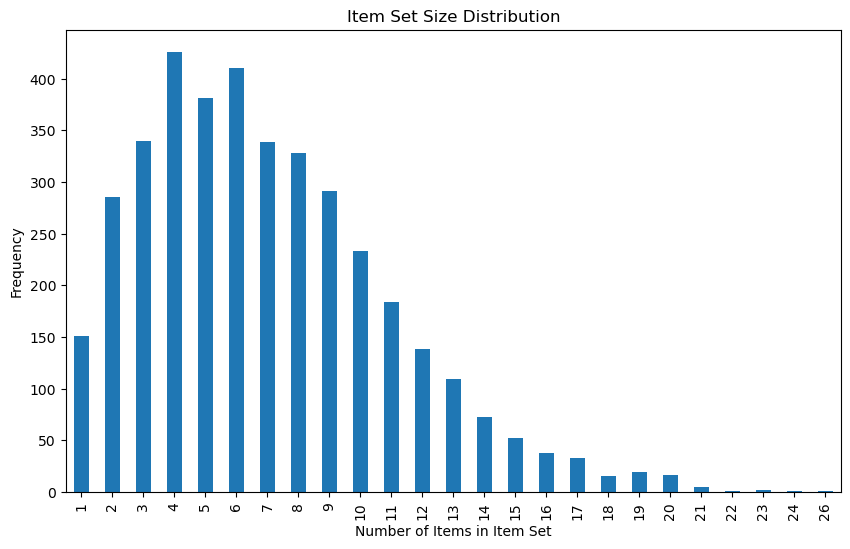

In [278]:
# Calculate the number of items in each frequent item set
train_transactions['itemset_size'] = train_transactions['itemDescription'].apply(len)

# Plotting the item set size distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
train_transactions['itemset_size'].value_counts().sort_index().plot(kind='bar')
plt.title('Item Set Size Distribution')
plt.xlabel('Number of Items in Item Set')
plt.ylabel('Frequency')
plt.show()

The distribution of item set sizes shows that most item sets contain between 4 and 6 items, with the frequency peaking at 4 items per set.

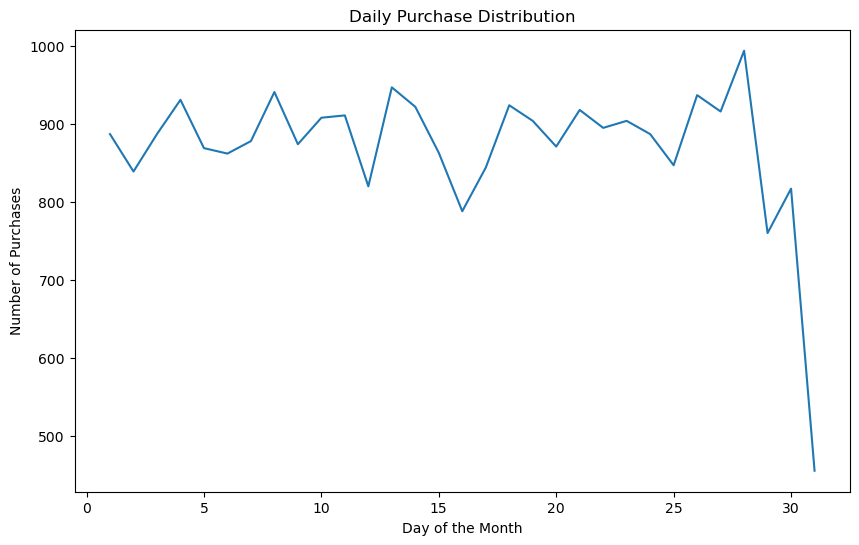

In [279]:
# Analysing the time distribution of purchases by day
daily_purchase = train_data['day'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=daily_purchase.index, y=daily_purchase.values)
plt.xlabel('Day of the Month')
plt.ylabel('Number of Purchases')
plt.title('Daily Purchase Distribution')
plt.show()

1. Purchasing behaviour peaks at the beginning and end of the month and on Thursdays, possibly due to the fact that Thursdays are paydays; overall weekly and monthly purchases remain stable, with a slight increase in August, which may be seasonally related. 
2. For collaborative filtering and correlation analysis, it is recommended to prioritise peak data, focusing on seasonal and regular product combinations to optimise recommendation strategies.

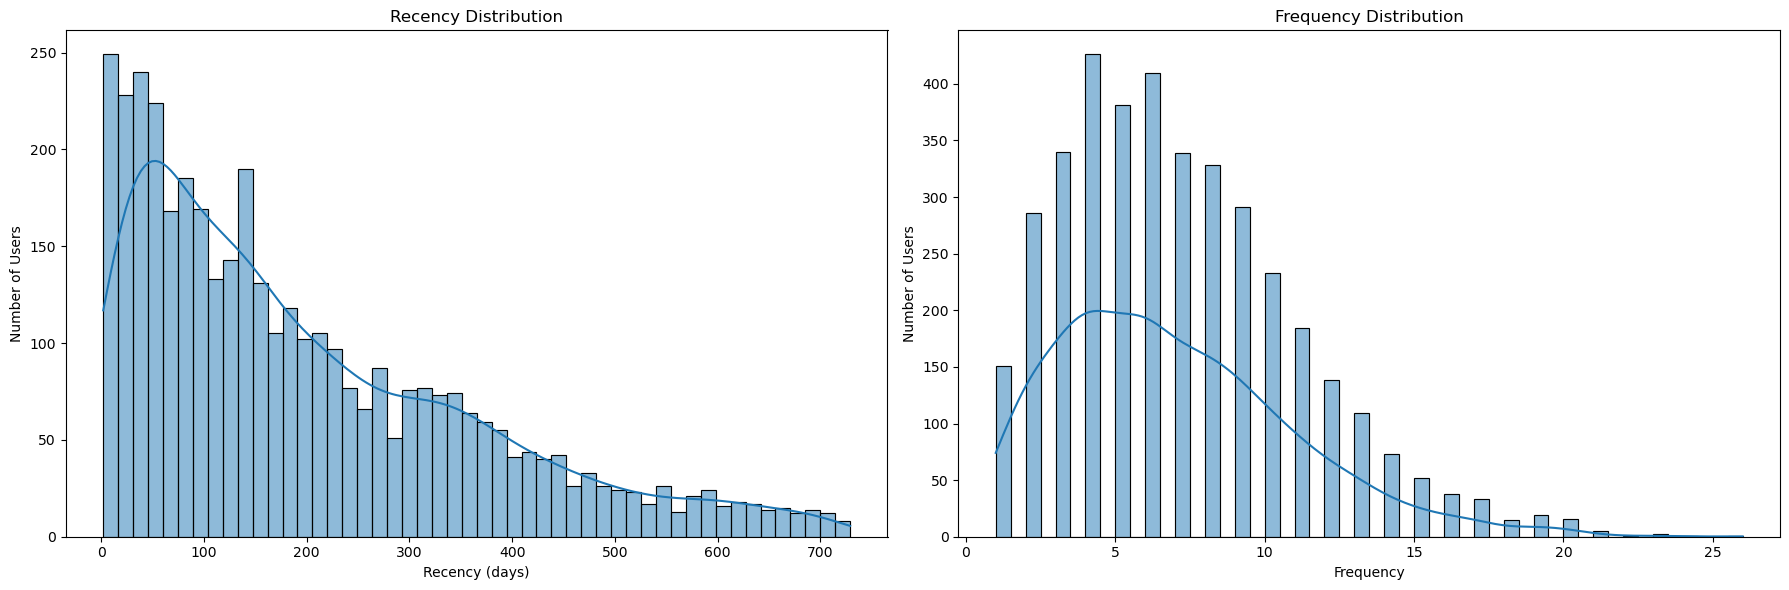

In [280]:
# Calculate the frequency of purchase for each user
import datetime as dt

train_data['Date'] = pd.to_datetime(train_data['Date'], format='%d/%m/%Y')
current_date = dt.datetime(2016, 1, 1)

rfm = train_data.groupby('Member_number').agg({
    'Date': lambda x: (current_date - x.max()).days,
    'Member_number': 'count'
}).rename(columns={
    'Date': 'Recency',
    'Member_number': 'Frequency'
}).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(rfm['Recency'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Recency Distribution')
ax[0].set_xlabel('Recency (days)')
ax[0].set_ylabel('Number of Users')

sns.histplot(rfm['Frequency'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('Frequency Distribution')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

Figure 1: 
* Peak concentration at 0-100 days: most users' most recent purchases occur within 0 to 100 days, indicating that these users have been active in purchasing behaviour in the recent past.
* Long Tail Effect: The number of users decreases as the time interval increases, but there are still some users who make purchases after longer intervals.

Figure 2: 
* Peak Concentration at 4 to 8 times: The majority of users make purchases between 4 and 8 times, showing that the main purchasing behaviour of users is concentrated in this frequency interval.
* Decreasing Trend: the number of users gradually decreases as the frequency of purchases increases, with relatively few users making high-frequency purchases.

Collaborative filtering:
* Active users priority: in collaborative filtering, you can prioritise the data of active users in the last 100 days, whose purchasing behaviour is more representative.
* Segmented modelling: user data is processed in segments according to purchase frequency and amount to improve the accuracy and relevance of recommendations.

Association Rule:
* focus on analysing association Rule with a frequency of 4 to 8 purchases, which are more likely to reflect the purchasing preferences of most users.
* High-frequency association: Focusing on a few users with high frequency purchases and mining the combinations of high-frequency association that they purchase.

Merchandise sales analysis

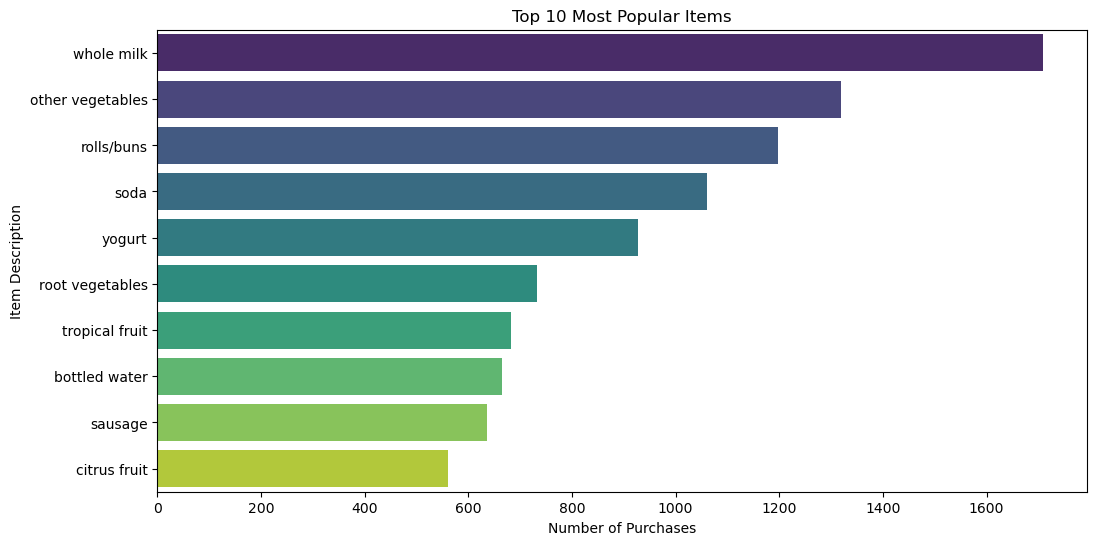

In [281]:
# Check the top 10 items
popular_items = train_data['itemDescription'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=popular_items.values, y=popular_items.index, palette='viridis')
plt.xlabel('Number of Purchases')
plt.ylabel('Item Description')
plt.title('Top 10 Most Popular Items')
plt.show()

Hot items :

* Daily necessities: most of the top ten items are necessities for daily consumption (e.g. Whole Milk, Other Vegetables, Soda, etc.), and consumers will prioritise these items when shopping.
* High Demand and Stability: These items have high demand and purchasing stability, and consumers naturally choose these items, so no special recommendation is needed.

**Observation:** 

1. The recommender system should give priority to the data of active users in the last 100 days and perform segmented modelling for users with different purchase frequencies and amounts to improve the accuracy and relevance of recommendations. 
2. The recommender system should focus on non-essential and low-frequency purchase goods, and provide personalised recommendations by combining users' historical purchase data and seasonal needs, avoiding generalised recommendations for high-frequency goods.

### 3. Data Processing : 

pip install mlxtend

In [282]:
import matplotlib.pyplot
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

#### 3.1 Frequent Pattern mining

pip install mlxtend

#### Apriori Algorithm

pip install apyori

#### Train Pattern

In [283]:
from apyori import apriori

rules = apriori(train_items, min_support=0.003, use_colnames=True)
Results = list(rules)
apri_trainData = pd.DataFrame(Results)
apri_trainData

,items,support,ordered_statistics
0,(abrasive cleaner),0.003099,"[((), (abrasive cleaner), 0.003099173553719008..."
1,(artif. sweetener),0.005424,"[((), (artif. sweetener), 0.005423553719008265..."
2,(baking powder),0.022211,"[((), (baking powder), 0.02221074380165289, 1.0)]"
3,(beef),0.090134,"[((), (beef), 0.09013429752066116, 1.0)]"
4,(berries),0.057335,"[((), (berries), 0.057334710743801656, 1.0)]"
...,...,...,...
5371,"(sausage, other vegetables, whole milk, soda, ...",0.003357,"[((), (soda, rolls/buns, sausage, other vegeta..."
5372,"(sausage, other vegetables, whole milk, yogurt...",0.003874,"[((), (yogurt, rolls/buns, sausage, other vege..."
5373,"(shopping bags, other vegetables, whole milk, ...",0.003099,"[((), (shopping bags, soda, rolls/buns, other ..."
5374,"(other vegetables, whole milk, soda, yogurt, r...",0.003099,"[((), (soda, yogurt, rolls/buns, other vegetab..."


In [284]:
apri_trainData.to_csv('apri_trainData.csv', index=False)

In [285]:
# user_itemsets = []

# for user_id in train_user_ids:
#     user_transactions = set(train_data[train_data['Member_number'] == user_id]['itemDescription'].tolist())
#     for _, rule in apri_trainData.iterrows():
#         if set(rule['items']).issubset(user_transactions):
#             user_itemsets.append({
#                 'user_id': user_id,
#                 'itemsets': rule['items'],
#                 'support': rule['support'],
#                 'ordered_statistics': rule['ordered_statistics']
                
#             })

# # transfer to DataFrame
# user_apri_trainData = pd.DataFrame(user_itemsets)
# user_apri_trainData.sort_values(by=['support'], ascending=False).head(20)

In [286]:
from mlxtend.frequent_patterns import association_rules
apri_trainData.rename(columns={'items': 'itemsets'}, inplace=True)
apri_train_rules = association_rules(apri_trainData, metric="confidence", min_threshold=0.1)
apri_train_rules.sort_values(by=['confidence'], ascending=False).head(100)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
10631,"(soda, brown bread, curd)",(whole milk),0.003616,0.347366,0.003357,0.928571,2.673181,0.002101,9.136880,0.628185
11157,"(sausage, canned beer, whipped/sour cream)",(whole milk),0.003616,0.347366,0.003357,0.928571,2.673181,0.002101,9.136880,0.628185
11356,"(specialty chocolate, whole milk, citrus fruit)",(other vegetables),0.004390,0.284866,0.003874,0.882353,3.097435,0.002623,6.078642,0.680138
11481,"(shopping bags, soda, coffee)",(other vegetables),0.003616,0.284866,0.003099,0.857143,3.008937,0.002069,5.005940,0.670079
13217,"(rolls/buns, sausage, uht-milk)",(whole milk),0.003616,0.347366,0.003099,0.857143,2.467552,0.001843,4.568440,0.596898
...,...,...,...,...,...,...,...,...,...,...
12768,"(sausage, other vegetables, uht-milk)",(whole milk),0.004649,0.347366,0.003099,0.666667,1.919207,0.001484,1.957903,0.481188
9741,"(pastry, bottled beer, other vegetables)",(whole milk),0.006973,0.347366,0.004649,0.666667,1.919207,0.002227,1.957903,0.482315
11123,"(shopping bags, root vegetables, canned beer)",(whole milk),0.004649,0.347366,0.003099,0.666667,1.919207,0.001484,1.957903,0.481188
9725,"(rolls/buns, bottled beer, citrus fruit)",(whole milk),0.004649,0.347366,0.003099,0.666667,1.919207,0.001484,1.957903,0.481188


#### Test Pattern

In [287]:
rules = apriori(test_items, min_support=0.003)
Results = list(rules)
apri_testData = pd.DataFrame(Results)
apri_testData

,items,support,ordered_statistics
0,(baking powder),0.010095,"[((), (baking powder), 0.010095344924284913, 1..."
1,(beef),0.039540,"[((), (beef), 0.039540100953449245, 1.0)]"
2,(berries),0.026360,"[((), (berries), 0.026360067302299495, 1.0)]"
3,(beverages),0.021032,"[((), (beverages), 0.021031968592260235, 1.0)]"
4,(bottled beer),0.052159,"[((), (bottled beer), 0.05215928210880538, 1.0)]"
...,...,...,...
510,"(soda, other vegetables, yogurt)",0.003365,"[((), (soda, other vegetables, yogurt), 0.0033..."
511,"(other vegetables, whole milk, yogurt)",0.004767,"[((), (other vegetables, whole milk, yogurt), ..."
512,"(rolls/buns, tropical fruit, yogurt)",0.003085,"[((), (rolls/buns, tropical fruit, yogurt), 0...."
513,"(rolls/buns, whole milk, yogurt)",0.003085,"[((), (rolls/buns, whole milk, yogurt), 0.0030..."


In [288]:
apri_testData.to_csv('apri_testData.csv', index=False)

In [289]:
# user_itemsets = []

# for user_id in test_user_ids:
#     user_transactions = set(test_data[train_data['Member_number'] == user_id]['itemDescription'].tolist())
#     for _, rule in apri_testData.iterrows():
#         if set(rule['items']).issubset(user_transactions):
#             user_itemsets.append({
#                 'user_id': user_id,
#                 'itemsets': rule['items'],
#                 'support': rule['support'],
#                 'ordered_statistics': rule['ordered_statistics']
                
#             })

# # transfer to DataFrame
# user_apri_testData = pd.DataFrame(user_itemsets)
# user_apri_testData.sort_values(by=['support'], ascending=False).head(20)

In [290]:
apri_testData.rename(columns={'items': 'itemsets'}, inplace=True)
apri_test_rules = association_rules(apri_testData, metric="confidence", min_threshold=0.1)
apri_test_rules.sort_values(by=['confidence'], ascending=False).head(100)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
316,"(shopping bags, root vegetables)",(whole milk),0.007572,0.199663,0.003085,0.407407,2.040470,0.001573,1.350568,0.513807
54,(cat food),(whole milk),0.014582,0.199663,0.005048,0.346154,1.733686,0.002136,1.224044,0.429457
299,"(shopping bags, other vegetables)",(whole milk),0.008974,0.199663,0.003085,0.343750,1.721647,0.001293,1.219560,0.422956
45,(cake bar),(whole milk),0.009254,0.199663,0.003085,0.333333,1.669476,0.001237,1.200505,0.404755
281,"(rolls/buns, bottled beer)",(whole milk),0.009254,0.199663,0.003085,0.333333,1.669476,0.001237,1.200505,0.404755
...,...,...,...,...,...,...,...,...,...,...
121,(fruit/vegetable juice),(whole milk),0.041223,0.199663,0.007572,0.183673,0.919915,-0.000659,0.980412,-0.083241
254,(specialty chocolate),(soda),0.019910,0.118340,0.003646,0.183099,1.547226,0.001289,1.079274,0.360867
175,(oil),(tropical fruit),0.019910,0.092821,0.003646,0.183099,1.972597,0.001797,1.110512,0.503070
34,(brown bread),(whole milk),0.042905,0.199663,0.007852,0.183007,0.916575,-0.000715,0.979612,-0.086840


#### FP-growth Algorithm

#### Train Pattern

In [291]:
# TrainData
# Using TransactionEncoder to transfer data
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(train_items).transform(train_items)
trans_train_data = pd.DataFrame(te_ary, columns=te.columns_)
trans_train_data.index = train_user_ids

trans_train_data

,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,...,uht-milk,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
3021,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1292,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4206,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,True,False,False
4369,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1522,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4630,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3605,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1459,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4386,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [292]:
from mlxtend.frequent_patterns import fpgrowth

frequent_Trainitemsets = fpgrowth(trans_train_data, min_support=0.005, use_colnames=True)
frequent_Trainitemsets

,support,itemsets
0,0.169421,(root vegetables)
1,0.159866,(bottled water)
2,0.101498,(frankfurter)
3,0.090134,(fruit/vegetable juice)
4,0.055269,(onions)
...,...,...
2350,0.006198,"(frozen dessert, whole milk)"
2351,0.005424,"(whole milk, photo/film)"
2352,0.006973,"(cling film/bags, whole milk)"
2353,0.005424,"(soda, cling film/bags)"


In [293]:
frequent_Trainitemsets.to_csv('fp_trainData.csv', index=False)

In [294]:
from mlxtend.frequent_patterns import association_rules

fp_train_rules = association_rules(frequent_Trainitemsets, metric="confidence", min_threshold=0.1)

fp_train_rules = fp_train_rules.rename(columns={'antecedents': 'antecedent'})
fp_train_rules = fp_train_rules.rename(columns={'consequents': 'consequent'})

fp_train_rules.sort_values(by=['confidence'], ascending=False).head(20)

,antecedent,consequent,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1198,"(sausage, rolls/buns, whipped/sour cream)",(whole milk),0.006973,0.347366,0.005424,0.777778,2.239075,0.003001,2.936854,0.557273
1183,"(sausage, whipped/sour cream, yogurt)",(whole milk),0.007231,0.347366,0.005165,0.714286,2.056293,0.002653,2.284220,0.517430
1003,"(bottled beer, other vegetables, bottled water)",(whole milk),0.009039,0.347366,0.006198,0.685714,1.974041,0.003058,2.076564,0.497926
737,"(other vegetables, pork, yogurt)",(whole milk),0.008006,0.347366,0.005424,0.677419,1.950162,0.002642,2.023166,0.491154
5060,"(ham, root vegetables)",(whole milk),0.008781,0.347366,0.005940,0.676471,1.947431,0.002890,2.017233,0.490813
4250,"(other vegetables, curd, yogurt)",(whole milk),0.008264,0.347366,0.005424,0.656250,1.889219,0.002553,1.898573,0.474603
1813,"(pip fruit, chocolate)",(whole milk),0.010331,0.347366,0.006715,0.650000,1.871227,0.003126,1.864669,0.470451
1190,"(sausage, soda, whipped/sour cream)",(whole milk),0.008006,0.347366,0.005165,0.645161,1.857297,0.002384,1.839242,0.465309
1785,"(other vegetables, chocolate, yogurt)",(whole milk),0.008006,0.347366,0.005165,0.645161,1.857297,0.002384,1.839242,0.465309
730,"(rolls/buns, pork, yogurt)",(whole milk),0.008006,0.347366,0.005165,0.645161,1.857297,0.002384,1.839242,0.465309


#### Test Pattern

In [295]:
# TrainData
# Using TransactionEncoder to transfer data
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(test_items).transform(test_items)
trans_test_data = pd.DataFrame(te_ary, columns=te.columns_)
trans_test_data.index = test_user_ids

trans_test_data

,abrasive cleaner,artif. sweetener,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,...,uht-milk,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
1000,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1003,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1004,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4999,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [296]:
from mlxtend.frequent_patterns import fpgrowth

frequent_Testitemsets = fpgrowth(trans_test_data, min_support=0.005, use_colnames=True)
frequent_Testitemsets

,support,itemsets
0,0.199663,(whole milk)
1,0.026360,(salty snack)
2,0.016545,(hygiene articles)
3,0.012900,(semi-finished bread)
4,0.046831,(frankfurter)
...,...,...
272,0.005889,"(rolls/buns, brown bread)"
273,0.005048,"(whole milk, meat)"
274,0.005048,"(ham, whole milk)"
275,0.006450,"(whole milk, sugar)"


In [297]:
frequent_Testitemsets.to_csv('fp_testData.csv', index=False)

In [298]:
from mlxtend.frequent_patterns import association_rules

fp_test_rules = association_rules(frequent_Testitemsets, metric="confidence", min_threshold=0.1)

fp_test_rules = fp_test_rules.rename(columns={'antecedents': 'antecedent'})
fp_test_rules = fp_test_rules.rename(columns={'consequents': 'consequent'})

fp_test_rules.sort_values(by=['confidence'], ascending=False).head(20)

,antecedent,consequent,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
111,(cat food),(whole milk),0.014582,0.199663,0.005048,0.346154,1.733686,0.002136,1.224044,0.429457
168,(sugar),(whole milk),0.022715,0.199663,0.006450,0.283951,1.422146,0.001915,1.117711,0.303737
101,(ice cream),(whole milk),0.019069,0.199663,0.005328,0.279412,1.399413,0.001521,1.110671,0.290963
99,(onions),(whole milk),0.024117,0.199663,0.006730,0.279070,1.397701,0.001915,1.110144,0.291571
29,(chocolate),(whole milk),0.028884,0.199663,0.007852,0.271845,1.361514,0.002085,1.099129,0.273421
12,"(rolls/buns, other vegetables)",(whole milk),0.023836,0.199663,0.006450,0.270588,1.355221,0.001691,1.097236,0.268514
167,(ham),(whole milk),0.019069,0.199663,0.005048,0.264706,1.325760,0.001240,1.088458,0.250492
63,(napkins),(whole milk),0.023556,0.199663,0.006169,0.261905,1.311731,0.001466,1.084327,0.243382
169,(sugar),(other vegetables),0.022715,0.151150,0.005889,0.259259,1.715248,0.002456,1.145948,0.426686
87,(shopping bags),(whole milk),0.063937,0.199663,0.016545,0.258772,1.296040,0.003779,1.079744,0.244021


#### 3.2 Evaluation the Patterns

In [299]:
# Function to evaluate and compare the rules
fp_train_sorted = fp_train_rules.sort_values(by=['confidence'], ascending=False).head(10)
apriori_train_sorted = apri_train_rules.sort_values(by=['confidence'], ascending=False).head(10)

fp_test_sorted = fp_test_rules.sort_values(by=['confidence'], ascending=False).head(10)
apriori_test_sorted = apri_train_rules.sort_values(by=['confidence'], ascending=False).head(10)

# Compare metrics
comparison_metrics = ['support', 'confidence', 'lift']
fp_train_means = fp_train_sorted[comparison_metrics].mean()
apriori_train_means = apriori_train_sorted[comparison_metrics].mean()
fp_test_means = fp_test_sorted[comparison_metrics].mean()
apriori_test_means = apriori_test_sorted[comparison_metrics].mean()
    
comparison = pd.DataFrame({
        'FP-growth_TrainData': fp_train_means,
        'FP-growth_TestData': fp_test_means,
        'Apriori_TrainData': apriori_train_means,
        'Apriori_TestData': apriori_test_means
})

comparison

,FP-growth_TrainData,FP-growth_TestData,Apriori_TrainData,Apriori_TestData
support,0.005579,0.007151,0.003512,0.003512
confidence,0.677340,0.277566,0.857878,0.857878
lift,1.949934,1.431846,2.630857,2.630857


For User-User Collaborative Filtering

To enhance the accuracy of our recommendation system, we classify users into high-frequency and low-frequency groups, with a particular focus on active users over the past 100 days. High-frequency users are those who have made frequent purchases in the last 100 days, while low-frequency users have made fewer purchases. This data processing approach allows us to better capture user behaviour characteristics, thereby improving the relevance and precision of our recommendations.

In [300]:
df_item = pd.read_csv('Groceries data train.csv')
df_item['Date'] = pd.to_datetime(df_item['Date'])

min_date = df_item['Date'].min()
max_date = df_item['Date'].max()
date_range = (max_date - min_date).days

print(f"Data range: {min_date} 到 {max_date}")
print(f"Days: {date_range} 天")

Data range: 2014-01-01 00:00:00 到 2015-12-30 00:00:00
Days: 728 天


In [301]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv('Groceries data train.csv')
df['Date'] = pd.to_datetime(df['Date'])

current_date = df['Date'].max()

recent_days = 100
recent_transactions = df[df['Date'] >= current_date - timedelta(days=recent_days)]

user_stats = recent_transactions.groupby('Member_number').agg({'itemDescription': 'count'}).reset_index()
user_stats.columns = ['Member_number', 'purchase_frequency']

frequency_threshold = user_stats['purchase_frequency'].median()

high_freq_users = user_stats[user_stats['purchase_frequency'] > frequency_threshold]
low_freq_users = user_stats[user_stats['purchase_frequency'] <= frequency_threshold]

print("High frequency users:")
print(high_freq_users.head())

print("Low frequency users:")
print(low_freq_users.head())

High frequency users:
   Member_number  purchase_frequency
3           1012                   4
4           1016                   4
6           1020                   4
7           1021                   4
8           1024                   4
Low frequency users:
   Member_number  purchase_frequency
0           1000                   1
1           1003                   1
2           1009                   1
5           1017                   1
9           1028                   2


For Item-Item Collaborative Filtering

In [302]:
df_item = pd.read_csv('Groceries data train.csv')
df_item['Date'] = pd.to_datetime(df_item['Date'])

current_date_item = df_item['Date'].max()

recent_days = 728
recent_transactions_item = df_item[df_item['Date'] >= current_date_item - timedelta(days=recent_days)]
print(recent_transactions_item.head())


   Member_number       Date  itemDescription  year  month  day  day_of_week
0           3021 2015-01-30      frankfurter  2015      1   30            4
1           1292 2015-10-24             pork  2015     10   24            5
2           4206 2014-04-04  root vegetables  2014      4    4            4
3           4369 2015-08-25           onions  2015      8   25            1
4           1522 2014-07-01          waffles  2014      7    1            1


### 4. Recommendation System:

Apriori algorithm

input2: patterns, output: recommendations.

In [303]:
df_pattern=pd.read_csv('apri_trainData.csv')

print(df_pattern.head)

<bound method NDFrame.head of                                                   items   support  \
0                       frozenset({'abrasive cleaner'})  0.003099   
1                       frozenset({'artif. sweetener'})  0.005424   
2                          frozenset({'baking powder'})  0.022211   
3                                   frozenset({'beef'})  0.090134   
4                                frozenset({'berries'})  0.057335   
...                                                 ...       ...   
5371  frozenset({'sausage', 'other vegetables', 'who...  0.003357   
5372  frozenset({'sausage', 'other vegetables', 'who...  0.003874   
5373  frozenset({'shopping bags', 'other vegetables'...  0.003099   
5374  frozenset({'other vegetables', 'whole milk', '...  0.003099   
5375  frozenset({'sausage', 'whole milk', 'soda', 'y...  0.003874   

                                     ordered_statistics  
0     [OrderedStatistic(items_base=frozenset(), item...  
1     [OrderedStatistic(i

In [304]:
import matplotlib.pyplot
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

# Since the data seems to be in a string format, we need to convert it into a list of lists
transactions = df_pattern['items'].apply(lambda x: eval(x)).tolist()

# Use TransactionEncoder to transform the data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)


df = pd.DataFrame(te_ary, columns=te.columns_)

start_time = time.time()
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)
frequent_itemsets
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for apriori algorithm: {elapsed_time:.2f} seconds")

from mlxtend.frequent_patterns import association_rules
start_time = time.time()
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
end_time = time.time()
elapsed_time_rules = end_time - start_time
print(f"Elapsed time for association rules: {elapsed_time_rules:.2f} seconds")
rules

Elapsed time for apriori algorithm: 0.12 seconds
Elapsed time for association rules: 0.00 seconds


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(bottled beer),(other vegetables),0.060268,0.198847,0.011161,0.185185,0.931296,-0.000823,0.983234,-0.072789
1,(bottled beer),(whole milk),0.060268,0.256696,0.015811,0.262346,1.022008,0.000340,1.007658,0.022915
2,(bottled water),(other vegetables),0.095238,0.198847,0.018415,0.193359,0.972404,-0.000523,0.993197,-0.030412
3,(bottled water),(rolls/buns),0.095238,0.177269,0.014509,0.152344,0.859391,-0.002374,0.970595,-0.153143
4,(soda),(bottled water),0.153088,0.095238,0.015625,0.102066,1.071689,0.001045,1.007604,0.078985
5,(bottled water),(soda),0.095238,0.153088,0.015625,0.164062,1.071689,0.001045,1.013129,0.073935
6,(bottled water),(whole milk),0.095238,0.256696,0.024740,0.259766,1.011957,0.000292,1.004146,0.013059
7,(brown bread),(other vegetables),0.056734,0.198847,0.010417,0.183607,0.923357,-0.000865,0.981332,-0.080880
8,(brown bread),(whole milk),0.056734,0.256696,0.014137,0.249180,0.970720,-0.000426,0.989989,-0.030987
9,(canned beer),(whole milk),0.057664,0.256696,0.014881,0.258065,1.005330,0.000079,1.001844,0.005626


In [305]:
start_time = time.time()
def predict_items(purchased_items, rules, n=10):
    applicable_rules = rules[rules['antecedents'].apply(lambda x: x.issubset(purchased_items))]
    sorted_rules = applicable_rules.sort_values(by='confidence', ascending=False)
    recommended_items = set()
    for _, row in sorted_rules.iterrows():
        recommended_items.update(row['consequents'])
        if len(recommended_items) >= n:
            break
    return list(recommended_items)[:n]

In [306]:
df_train = pd.read_csv('Groceries data train.csv')
print(df_train.columns)

Index(['Member_number', 'Date', 'itemDescription', 'year', 'month', 'day',
       'day_of_week'],
      dtype='object')


In [307]:
# make a prediction for trainset
user_purchased_items = df_train.groupby('Member_number')['itemDescription'].apply(lambda x: set(x))

user_recommendations = []
for Member_number, purchased_items in user_purchased_items.items():
    predicted_items = predict_items(purchased_items, rules)
    for item in predicted_items:
        user_recommendations.append((Member_number, item))

recommendations_df = pd.DataFrame(user_recommendations, columns=['Member_number', 'Recommendation_item'])

recommendations_df.to_csv('user_recommendations_Apriori.csv', index=False)

end_time = time.time()
elapsed_time_recommendations = end_time - start_time
print(f"Elapsed time for recommendations: {elapsed_time_recommendations:.2f} seconds")

print("Recommendations for users (head):")
print(recommendations_df.head())

Elapsed time for recommendations: 7.44 seconds
Recommendations for users (head):
   Member_number Recommendation_item
0           1000                soda
1           1000             sausage
2           1000              yogurt
3           1000          rolls/buns
4           1000    other vegetables


In [308]:
current_num_transactions = len(transactions)
current_num_items = len(df.columns)
T_A = elapsed_time + elapsed_time_rules + elapsed_time_recommendations

target_num_transactions = 1000000  
target_num_items = current_num_items  

growth_factor_transactions = target_num_transactions / current_num_transactions

T_B_apri = T_A * growth_factor_transactions

print(f"Estimated time for large dataset: {T_B_apri:.2f} seconds")

Estimated time for large dataset: 1407.06 seconds


FP-growth algorithm

Input2: patterns, output: recommendations.

In [309]:
df_pattern_FP=pd.read_csv('frequent_Trainitemsets.csv')

print(df_pattern_FP.head)

<bound method NDFrame.head of        support                                      itemsets
0     0.169421                frozenset({'root vegetables'})
1     0.159866                  frozenset({'bottled water'})
2     0.101498                    frozenset({'frankfurter'})
3     0.090134          frozenset({'fruit/vegetable juice'})
4     0.055269                         frozenset({'onions'})
...        ...                                           ...
2350  0.006198   frozenset({'frozen dessert', 'whole milk'})
2351  0.005424       frozenset({'photo/film', 'whole milk'})
2352  0.006973  frozenset({'cling film/bags', 'whole milk'})
2353  0.005424        frozenset({'cling film/bags', 'soda'})
2354  0.006457  frozenset({'rolls/buns', 'cling film/bags'})

[2355 rows x 2 columns]>


In [310]:
# Since the data seems to be in a string format, we need to convert it into a list of lists
transactions = df_pattern_FP['itemsets'].apply(lambda x: eval(x)).tolist()

# Use TransactionEncoder to transform the data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

start_time = time.time()
frequent_itemsets = fpgrowth(df, min_support=0.01, use_colnames=True)
frequent_itemsets
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for apriori algorithm: {elapsed_time:.2f} seconds")

from mlxtend.frequent_patterns import association_rules
start_time = time.time()
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
end_time = time.time()
elapsed_time_rules = end_time - start_time
print(f"Elapsed time for association rules: {elapsed_time_rules:.2f} seconds")
rules

Elapsed time for apriori algorithm: 0.02 seconds
Elapsed time for association rules: 0.02 seconds


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(root vegetables),(whole milk),0.084501,0.248408,0.018259,0.216080,0.869862,-0.002732,0.958762,-0.140462
1,(root vegetables),(rolls/buns),0.084501,0.159660,0.013588,0.160804,1.007163,0.000097,1.001363,0.007769
2,(root vegetables),(other vegetables),0.084501,0.186837,0.014437,0.170854,0.914459,-0.001351,0.980724,-0.092705
3,(root vegetables),(soda),0.084501,0.138854,0.011040,0.130653,0.940943,-0.000693,0.990567,-0.064158
4,(bottled water),(other vegetables),0.083652,0.186837,0.016561,0.197970,1.059587,0.000931,1.013881,0.061370
5,(bottled water),(rolls/buns),0.083652,0.159660,0.011890,0.142132,0.890215,-0.001466,0.979568,-0.118618
6,(bottled water),(whole milk),0.083652,0.248408,0.020807,0.248731,1.001302,0.000027,1.000430,0.001419
7,(bottled water),(soda),0.083652,0.138854,0.011890,0.142132,1.023611,0.000274,1.003822,0.025172
8,(rolls/buns),(whole milk),0.159660,0.248408,0.037367,0.234043,0.942171,-0.002294,0.981246,-0.068068
9,(whole milk),(rolls/buns),0.248408,0.159660,0.037367,0.150427,0.942171,-0.002294,0.989132,-0.075499


In [311]:
start_time = time.time()
def predict_items(purchased_items):
    predicted_items = []
    for index, row in rules.iterrows():
        antecedent = row["antecedents"]
        consequent = row["consequents"]
        if antecedent.issubset(purchased_items):
            predicted_items.append((consequent, row["confidence"]))
    predicted_items = sorted(predicted_items, key=lambda x: x[1], reverse=True)[:10]  # Take top 10 recommendations
    return [item for sublist in predicted_items for item in sublist[0]]


In [312]:
df_train = pd.read_csv('Groceries data train.csv')
print(df_train.columns)

Index(['Member_number', 'Date', 'itemDescription', 'year', 'month', 'day',
       'day_of_week'],
      dtype='object')


In [313]:
user_purchased_items = df_train.groupby('Member_number')['itemDescription'].apply(lambda x: set(x))

user_recommendations = []
for Member_number, purchased_items in user_purchased_items.items():
    predicted_items = predict_items(purchased_items)
    for item in predicted_items:
        user_recommendations.append((Member_number, item))

recommendations_df = pd.DataFrame(user_recommendations, columns=['Member_number', 'Recommendation_item'])

recommendations_df.to_csv('user_recommendations_FP.csv', index=False)

end_time = time.time()
elapsed_time_recommendations = end_time - start_time
print(f"Elapsed time for recommendations: {elapsed_time_recommendations:.2f} seconds")

print("Recommendations for users (head):")
print(recommendations_df.head())

Elapsed time for recommendations: 11.43 seconds
Recommendations for users (head):
   Member_number Recommendation_item
0           1000          whole milk
1           1000          whole milk
2           1000          whole milk
3           1000          whole milk
4           1000          whole milk


In [314]:
current_num_transactions = len(transactions)
current_num_items = len(df.columns)
T_A = elapsed_time + elapsed_time_rules + elapsed_time_recommendations

target_num_transactions = 1000000  
target_num_items = current_num_items  

growth_factor_transactions = target_num_transactions / current_num_transactions

T_B_FP = T_A * growth_factor_transactions

print(f"Estimated time for large dataset: {T_B_FP:.2f} seconds")

Estimated time for large dataset: 4867.69 seconds


#### User-User Collaborative Filtering

Input1: raw data, output: recommendations. 

In [315]:
# 2
# Cosine Similarity
def similarity(user1, user2):
    dot_product = np.dot(user1, user2)
    magnitude = np.sqrt(np.sum(user1 ** 2) * np.sum(user2 ** 2))
    if magnitude == 0:
        return 0
    return dot_product / magnitude

def predict_rating(target_user_ratings, item_ratings, user_item_matrix):
    rated_indices = np.where(item_ratings != 0)[0]
    if len(rated_indices) == 0:
        return 0
    
    ratings = item_ratings[rated_indices]
    similarities = []
    
    for i in rated_indices:
        similar_user_ratings = user_item_matrix[i]
        sim = similarity(target_user_ratings, similar_user_ratings)
        similarities.append(sim)
    
    similarities = np.array(similarities)
    
    if np.sum(similarities) == 0:
        return 0
    
    weighted_sum = np.dot(similarities, ratings)
    weighted_sum /= np.sum(similarities)
    return weighted_sum

def recommend_items(user_ratings, target_user_id, user_item_matrix, n=10):
    target_user_ratings = user_ratings.loc[target_user_id].values
    unpurchased_indices = np.where(target_user_ratings == 0)[0]
    predicted_ratings = [predict_rating(target_user_ratings, user_ratings.iloc[:, item_index].values, user_item_matrix) for item_index in unpurchased_indices]
    sorted_indices = np.argsort(predicted_ratings)[::-1]
    top_items = sorted_indices[:n]
    recommended_items = [(user_ratings.columns[item_index], predicted_ratings[item_index]) for item_index in top_items]
    return recommended_items

In [316]:
def measure_time(user_item_matrix, user_ids, n=10, iterations=100):
    total_time = 0
    for _ in range(iterations):
        start_time = time.time()
        for user_id in user_ids:
            recommend_items(user_item_matrix, user_id, user_item_matrix.values, n)
        end_time = time.time()
        total_time += (end_time - start_time)
    average_time = total_time / iterations
    return average_time

In [317]:
def create_user_item_matrix(transactions):
    transactions['rating'] = 1
    user_item_matrix = transactions.pivot_table(index='Member_number', columns='itemDescription', values='rating', aggfunc='sum', fill_value=0)
    return user_item_matrix

high_freq_transactions = recent_transactions[recent_transactions['Member_number'].isin(high_freq_users['Member_number'])]
low_freq_transactions = recent_transactions[recent_transactions['Member_number'].isin(low_freq_users['Member_number'])]

high_freq_matrix = create_user_item_matrix(high_freq_transactions)
low_freq_matrix = create_user_item_matrix(low_freq_transactions)

target_user_id = high_freq_matrix.index[0]
recommended_items_high_freq = recommend_items(high_freq_matrix, target_user_id, high_freq_matrix.values, n=10)
print("Recommended items for high frequency user", target_user_id, ":", recommended_items_high_freq)

target_user_id = low_freq_matrix.index[0]
recommended_items_low_freq = recommend_items(low_freq_matrix, target_user_id, low_freq_matrix.values, n=10)
print("Recommended items for low frequency user", target_user_id, ":", recommended_items_low_freq)

Recommended items for high frequency user 1012 : [('canned fish', 1.3483314773547883), ('fruit/vegetable juice', 1.1565764348130227), ('whipped/sour cream', 1.1541109846922553), ('organic sausage', 1.1409095612990392), ('other vegetables', 1.1164089137019748), ('domestic eggs', 1.1049132229115906), ('pickled vegetables', 1.0990831604075755), ('misc. beverages', 1.0916806987058596), ('dessert', 1.088607113214343), ('roll products ', 1.0846036277506486)]
Recommended items for low frequency user 1000 : [('cream cheese ', 1.0), ('packaged fruit/vegetables', 1.0), ('napkins', 1.0), ('chocolate', 1.0), ('salt', 1.0), ('meat', 1.0), ('root vegetables', 1.0), ('rolls/buns', 1.0), ('semi-finished bread', 1.0), ('whole milk', 1.0)]


In [318]:
high_freq_user_ids = high_freq_matrix.index[:10]  
low_freq_user_ids = low_freq_matrix.index[:10]   

average_time_high_freq = measure_time(high_freq_matrix, high_freq_user_ids, n=10, iterations=100)
print(f"Average time for high frequency users: {average_time_high_freq:.2f} seconds")

average_time_low_freq = measure_time(low_freq_matrix, low_freq_user_ids, n=10, iterations=100)
print(f"Average time for low frequency users: {average_time_low_freq:.2f} seconds")

N_A = len(high_freq_matrix.index)
M_A = len(high_freq_matrix.columns)
T_A = average_time_high_freq  

N_B = 1000000
M_B = 1000

T_B_user = T_A * (N_B**2 * M_B) / (N_A**2 * M_A)
print(f"Estimated time for large dataset: {T_B_user:.2f} seconds")

Average time for high frequency users: 0.61 seconds
Average time for low frequency users: 0.37 seconds
Estimated time for large dataset: 11807893.99 seconds


In [319]:
high_freq_recommendations = []
low_freq_recommendations = []

for user_id in high_freq_matrix.index:
    recommendations = recommend_items(high_freq_matrix, user_id, high_freq_matrix.values, n=10)
    for item, score in recommendations:
        high_freq_recommendations.append([user_id, item, score])

for user_id in low_freq_matrix.index:
    recommendations = recommend_items(low_freq_matrix, user_id, low_freq_matrix.values,n=10)
    for item, score in recommendations:
        low_freq_recommendations.append([user_id, item, score])

high_freq_recommendations_df = pd.DataFrame(high_freq_recommendations, columns=['user_id', 'Recommendation_item', 'Predicted_ratings'])
low_freq_recommendations_df = pd.DataFrame(low_freq_recommendations, columns=['user_id', 'Recommendation_item', 'Predicted_ratings'])

high_freq_recommendations_df.to_csv('high_freq_user_recommendations.csv', index=False)
low_freq_recommendations_df.to_csv('low_freq_user_recommendations.csv', index=False)

print("High frequency user recommendations:")
print(high_freq_recommendations_df.head())

print("\nLow frequency user recommendations:")
print(low_freq_recommendations_df.head())

High frequency user recommendations:
   user_id    Recommendation_item  Predicted_ratings
0     1012            canned fish           1.348331
1     1012  fruit/vegetable juice           1.156576
2     1012     whipped/sour cream           1.154111
3     1012        organic sausage           1.140910
4     1012       other vegetables           1.116409

Low frequency user recommendations:
   user_id        Recommendation_item  Predicted_ratings
0     1000              cream cheese                 1.0
1     1000  packaged fruit/vegetables                1.0
2     1000                    napkins                1.0
3     1000                  chocolate                1.0
4     1000                       salt                1.0


#### Item-Item Collaborative Filtering

Input1: raw data, output: recommendations. 

In [320]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 3

recent_transactions_item['rating'] = 1

user_item_matrix = recent_transactions_item.pivot_table(index='Member_number', columns='itemDescription', values='rating')
user_item_matrix = user_item_matrix.fillna(0)

user_item_matrix.to_csv('user_item_matrix.csv',index=True)

start_time = time.time()
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

def get_item_based_recommendations(user_id, user_item_matrix, item_similarity_df, n=10):
    user_ratings = user_item_matrix.loc[user_id]
    similar_scores = item_similarity_df.dot(user_ratings).div(item_similarity_df.sum(axis=1))
    recommendations = similar_scores.sort_values(ascending=False).head(n)
    return recommendations

In [321]:
recommendations_list = []

for user_id in user_item_matrix.index:
    recs = get_item_based_recommendations(user_id, user_item_matrix, item_similarity_df, n=10)
    for item, score in recs.items():
        recommendations_list.append([user_id, item, score])

recommendations_df = pd.DataFrame(recommendations_list, columns=['user_id', 'Recommendation_item', 'Predicted_ratings'])
output_path = 'all_user_recommendations_itemtoitem.csv'
recommendations_df.to_csv(output_path, index=False)

print(recommendations_df)

       user_id Recommendation_item  Predicted_ratings
0         1000  pickled vegetables           0.235543
1         1000     misc. beverages           0.216883
2         1000         canned beer           0.159128
3         1000              pastry           0.153167
4         1000             sausage           0.149536
...        ...                 ...                ...
38715     5000       sliced cheese           0.061380
38716     5000      condensed milk           0.061376
38717     5000            cat food           0.059971
38718     5000               pasta           0.058839
38719     5000       cream cheese            0.058171

[38720 rows x 3 columns]


In [322]:
import time
for user_id in user_item_matrix.index:
    recs = get_item_based_recommendations(user_id, user_item_matrix, item_similarity_df, n=10)
    for item, score in recs.items():
        recommendations_list.append([user_id, item, score])

end_time = time.time()
elapsed_time = end_time - start_time

N_A = len(user_item_matrix.index)
M_A = len(user_item_matrix.columns)
T_A = elapsed_time

N_B = 1000000
M_B = 1000

similarity_time_complexity = (M_B**2 * N_B) / (M_A**2 * N_A)
recommendation_time_complexity = (N_B * M_B**2) / (N_A * M_A**2)

T_B_item = T_A * (similarity_time_complexity + recommendation_time_complexity)

print(f"Estimated time for large dataset: {T_B_item:.2f} seconds")

Estimated time for large dataset: 180268.13 seconds


### 5. Recommendation systems based on clustering

#### 5.1 Read the dataset based on task1 and task2

##### 5.1.1 Frequent itemsets dataset

In [323]:
# Read the data of frequent itemsets
df1=pd.read_csv("user_apri_trainData.csv")
df1.head(5)

,user_id,itemsets,support,ordered_statistics
0,1001,"frozenset({'curd', 'whole milk', 'whipped/sour...",0.003099,[OrderedStatistic(items_base=frozenset({'curd'...
1,1004,"frozenset({'rolls/buns', 'chocolate', 'whole m...",0.003099,[OrderedStatistic(items_base=frozenset({'rolls...
2,1004,"frozenset({'rolls/buns', 'other vegetables', '...",0.003099,[OrderedStatistic(items_base=frozenset({'whole...
3,1012,"frozenset({'whole milk', 'shopping bags', 'yog...",0.003874,[OrderedStatistic(items_base=frozenset({'yogur...
4,1028,"frozenset({'root vegetables', 'bottled water',...",0.003099,[OrderedStatistic(items_base=frozenset({'bottl...


In [324]:
#check if train data has null data
df1.isnull().sum()

user_id               0
itemsets              0
support               0
ordered_statistics    0
dtype: int64

##### 5.1.2 Collaborative filtering dataset

In [325]:
df2=pd.read_csv("high_freq_user_recommendations.csv")
df2.head()

,user_id,Recommendation_item,Predicted_ratings
0,1012,canned fish,1.348331
1,1012,fruit/vegetable juice,1.156576
2,1012,whipped/sour cream,1.154111
3,1012,organic sausage,1.140910
4,1012,other vegetables,1.116409


#### 5.2 Data Visualisation

##### 5.2.1 Frequent itemsets dataset analyze

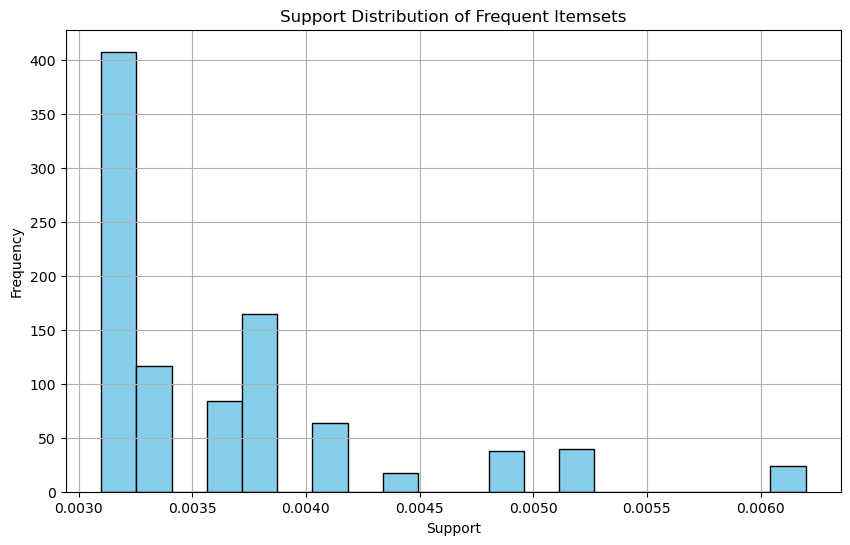

In [326]:
# Plotting the distribution of support
plt.figure(figsize=(10, 6))
plt.hist(df1['support'], bins=20, color='skyblue', edgecolor='black')
plt.title('Support Distribution of Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The highest number of frequent item sets with support around 0.0030 is over 300. 

The majority of frequent itemsets have support clustered in the lower range (0.0030 to 0.0040), indicating that most frequent itemsets occur relatively infrequently throughout the dataset.

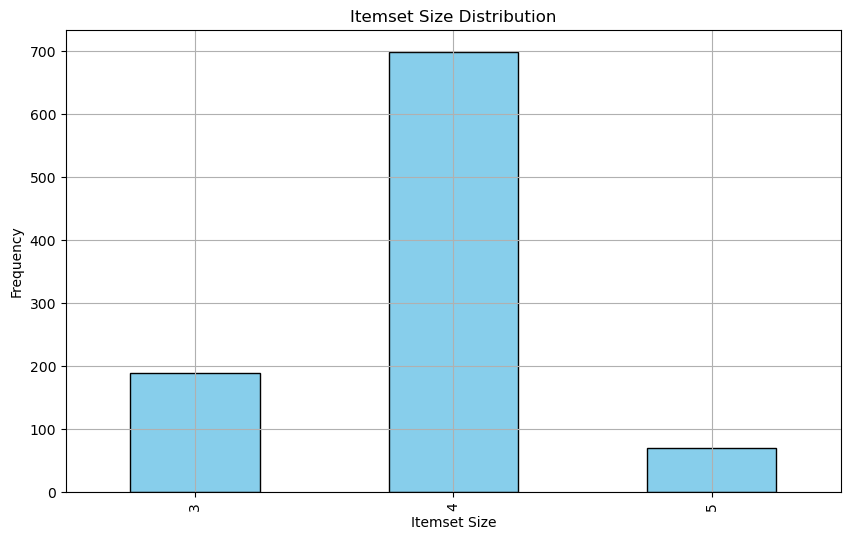

In [327]:
# Calculate the number of items in each frequent item set
df1['itemset_size'] = df1['itemsets'].apply(lambda x: len(eval(x)))

# Plotting the item set size distribution
plt.figure(figsize=(10, 6))
df1['itemset_size'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Itemset Size Distribution')
plt.xlabel('Itemset Size')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

From the figure, it can be seen that the size of the frequent itemsets is mainly concentrated between 3 and 5, especially the itemsets with 4 items are the most. This indicates that the combination of 4 items is the most common in customers' purchasing behaviour.

##### 5.2.2 collaborative filtering dataset analyze

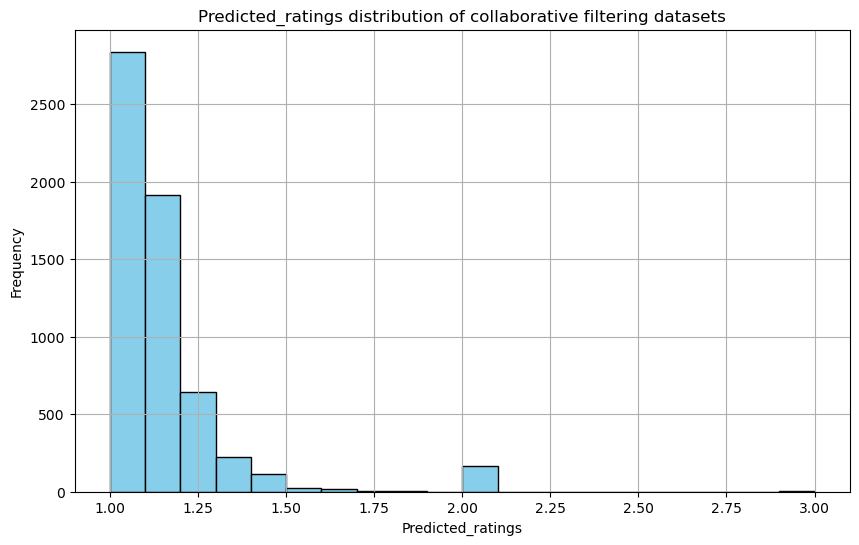

In [328]:
# Plotting the distribution of rating
plt.figure(figsize=(10, 6))
plt.hist(df2['Predicted_ratings'], bins=20, color='skyblue', edgecolor='black')
plt.title('Predicted_ratings distribution of collaborative filtering datasets')
plt.xlabel('Predicted_ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The chart shows that the majority of predicted scores are concentrated in the score band 1.1. This score band has the highest frequency of occurrence, with over 2500 occurrences.  
The distribution of predicted scores is concentrated between 1 and 1.25. This indicates that most of the recommended items have predicted scores within this range, implying that the system predicted scores are relatively close and concentrated.

#### 5.3 Building an integrated recommender system

According to reference 4, I have found a hybrid recommender system. The recommendation process is based on an integrated algorithm, with the sense that the integrated recommendation can save time and ensure better performance. 

For the ﬁrst stage, it employs association rules to divide customers into different groups and discover target customers who have more possibility to buy an item. 

In the second stage, it applies CF method to distinguishtop-N items for recommendation. In this way, it saves time and cost instead of recommending to those users who have no buying intention. 

##### 5.3.1 Using clustering and k-means to find similar users

In [329]:
# start time
start_time_clustering = time.time()

In [330]:
# Create a customer-item matrix
customer_item_matrix = df1.pivot_table(index='user_id', columns='itemsets', aggfunc='size', fill_value=0)
customer_item_matrix

itemsets,"frozenset({'bottled beer', 'frozen meals', 'tropical fruit'})","frozenset({'bottled beer', 'other vegetables', 'rolls/buns', 'tropical fruit'})","frozenset({'bottled beer', 'other vegetables', 'rolls/buns', 'whole milk', 'sausage'})","frozenset({'chicken', 'bottled water', 'butter'})","frozenset({'chicken', 'pip fruit', 'tropical fruit'})","frozenset({'chicken', 'shopping bags', 'soda', 'whole milk'})","frozenset({'curd', 'whole milk', 'soda', 'brown bread'})","frozenset({'curd', 'whole milk', 'whipped/sour cream', 'sausage'})","frozenset({'curd', 'whole milk', 'yogurt', 'sausage'})","frozenset({'dessert', 'shopping bags', 'brown bread'})",...,"frozenset({'whole milk', 'root vegetables', 'newspapers', 'sausage'})","frozenset({'whole milk', 'shopping bags', 'canned beer', 'sausage'})","frozenset({'whole milk', 'shopping bags', 'sausage', 'brown bread'})","frozenset({'whole milk', 'shopping bags', 'soda', 'canned beer'})","frozenset({'whole milk', 'shopping bags', 'soda', 'pork'})","frozenset({'whole milk', 'shopping bags', 'yogurt', 'brown bread'})","frozenset({'whole milk', 'soda', 'canned beer', 'brown bread'})","frozenset({'yogurt', 'other vegetables', 'rolls/buns', 'whole milk', 'sausage'})","frozenset({'yogurt', 'other vegetables', 'whole milk', 'bottled water', 'sausage'})","frozenset({'yogurt', 'soda', 'rolls/buns', 'whole milk', 'sausage'})"
user_id,,,,,,,,,,,,,,,,,,,,,
1001,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4933,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4939,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [331]:
# Apply OneHotEncoder
encoder = OneHotEncoder()
encoded_matrix = encoder.fit_transform(customer_item_matrix)
encoded_matrix

<505x140 sparse matrix of type '<class 'numpy.float64'>'
	with 35350 stored elements in Compressed Sparse Row format>

In [332]:
# Apply KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=0)

In [333]:
clusters = kmeans.fit_predict(encoded_matrix)
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [334]:
# Create a dictionary mapping user_id to cluster
user_clusters = {user_id: cluster for user_id, cluster in zip(customer_item_matrix.index, clusters)}

In [335]:
# Add cluster labels to the original data
df1['cluster'] = df1['user_id'].map(user_clusters)
df1

,user_id,itemsets,support,ordered_statistics,itemset_size,cluster
0,1001,"frozenset({'curd', 'whole milk', 'whipped/sour...",0.003099,[OrderedStatistic(items_base=frozenset({'curd'...,4,1
1,1004,"frozenset({'rolls/buns', 'chocolate', 'whole m...",0.003099,[OrderedStatistic(items_base=frozenset({'rolls...,4,1
2,1004,"frozenset({'rolls/buns', 'other vegetables', '...",0.003099,[OrderedStatistic(items_base=frozenset({'whole...,4,1
3,1012,"frozenset({'whole milk', 'shopping bags', 'yog...",0.003874,[OrderedStatistic(items_base=frozenset({'yogur...,4,1
4,1028,"frozenset({'root vegetables', 'bottled water',...",0.003099,[OrderedStatistic(items_base=frozenset({'bottl...,4,1
...,...,...,...,...,...,...
952,4952,"frozenset({'whole milk', 'beef', 'soda', 'cann...",0.003099,[OrderedStatistic(items_base=frozenset({'beef'...,4,1
953,4952,"frozenset({'whipped/sour cream', 'whole milk',...",0.003357,[OrderedStatistic(items_base=frozenset({'canne...,4,1
954,4952,"frozenset({'whipped/sour cream', 'whole milk',...",0.005165,[OrderedStatistic(items_base=frozenset({'whipp...,4,1
955,4953,"frozenset({'chicken', 'pip fruit', 'tropical f...",0.004132,[OrderedStatistic(items_base=frozenset({'chick...,3,1


In [336]:
# Aggregate itemsets per user in clusters
cluster_0_1_users = df1[(df1['cluster'] == 0) | (df1['cluster'] == 1)]
user_itemsets_agg = cluster_0_1_users.groupby(['cluster', 'user_id'])['itemsets'].apply(lambda x: list(x)).reset_index()
user_itemsets_agg

,cluster,user_id,itemsets
0,0,1170,"[frozenset({'whole milk', 'bottled water', 'so..."
1,0,1366,"[frozenset({'whipped/sour cream', 'waffles', '..."
2,0,1878,"[frozenset({'dessert', 'shopping bags', 'brown..."
3,0,1908,"[frozenset({'whole milk', 'beef', 'soda', 'can..."
4,0,2186,"[frozenset({'frankfurter', 'whole milk', 'bott..."
...,...,...,...
488,1,4933,"[frozenset({'curd', 'whole milk', 'yogurt', 's..."
489,1,4939,"[frozenset({'whole milk', 'soda', 'canned beer..."
490,1,4952,"[frozenset({'whole milk', 'beef', 'soda', 'can..."
491,1,4953,"[frozenset({'chicken', 'pip fruit', 'tropical ..."


In [337]:
# check the numbers of each cluster
print(user_itemsets_agg['cluster'].value_counts())

cluster
1    469
0     24
Name: count, dtype: int64


##### 5.3.2 Combine with collaborative filtering

In [338]:
# Filter CF recommendations for users in Cluster 0,1,2
cluster_0_1_users = user_itemsets_agg[['cluster', 'user_id']]
cluster_0_cf_recommendations = df2[df2['user_id'].isin(cluster_0_1_users['user_id'])]
cluster_0_cf_recommendations = cluster_0_cf_recommendations.merge(cluster_0_1_users, on='user_id', how='left')
cluster_0_cf_recommendations

,user_id,Recommendation_item,Predicted_ratings,cluster
0,1012,canned fish,1.348331,1
1,1012,fruit/vegetable juice,1.156576,1
2,1012,whipped/sour cream,1.154111,1
3,1012,organic sausage,1.140910,1
4,1012,other vegetables,1.116409,1
...,...,...,...,...
1555,4953,dessert,1.140456,1
1556,4953,turkey,1.136817,1
1557,4953,mayonnaise,1.093046,1
1558,4953,vinegar,1.077614,1


In [339]:
# Create a combined recommendations DataFrame
combined_recommendations = []

for _, row in cluster_0_1_users.iterrows():
    user_id = row['user_id']
    cluster = row['cluster']
    
    # Get frequent itemsets for the user
    user_itemsets = user_itemsets_agg[user_itemsets_agg['user_id'] == user_id]['itemsets'].values[0]
    
    # Get CF recommendations for the user
    user_cf_recommendations = cluster_0_cf_recommendations[cluster_0_cf_recommendations['user_id'] == user_id]
    
    # Combine recommendations
    for _, cf_row in user_cf_recommendations.iterrows():
        combined_recommendations.append({
            'user_id': user_id,
            'cluster': cluster,
            'Frequent_itemsets': user_itemsets,
            'CF_Recommendation': cf_row['Recommendation_item'],
            'Predicted_rating': cf_row['Predicted_ratings']
        })

combined_recommendations_df = pd.DataFrame(combined_recommendations)
combined_recommendations_df

,user_id,cluster,Frequent_itemsets,CF_Recommendation,Predicted_rating
0,1170,0,"[frozenset({'whole milk', 'bottled water', 'so...",dental care,1.176610
1,1170,0,"[frozenset({'whole milk', 'bottled water', 'so...",canned beer,1.144888
2,1170,0,"[frozenset({'whole milk', 'bottled water', 'so...",long life bakery product,1.097548
3,1170,0,"[frozenset({'whole milk', 'bottled water', 'so...",dishes,1.085826
4,1170,0,"[frozenset({'whole milk', 'bottled water', 'so...",mayonnaise,1.085578
...,...,...,...,...,...
1555,4953,1,"[frozenset({'chicken', 'pip fruit', 'tropical ...",dessert,1.140456
1556,4953,1,"[frozenset({'chicken', 'pip fruit', 'tropical ...",turkey,1.136817
1557,4953,1,"[frozenset({'chicken', 'pip fruit', 'tropical ...",mayonnaise,1.093046
1558,4953,1,"[frozenset({'chicken', 'pip fruit', 'tropical ...",vinegar,1.077614


The table shows how both frequent itemsets and collaborative filtering can be used together to generate personalized recommendations for each user.

Frequent Itemsets: Indicates the typical combinations of items that the user tends to purchase. For instance, user 1170 often buys combinations like frozenset({'bottled water', 'canned beer', 'whole milk'}).

CF Recommendations: Lists specific items that the collaborative filtering model predicts the user might like, based on the purchasing patterns of similar users. For example, the CF model recommends dental care, canned beer, long life bakery product for user 1170 with predicted ratings of 1.17, 1.14, and 1.09, respectively.

Predicted Ratings: Higher ratings suggest a stronger likelihood that the user will be interested in the recommended item.

#### 5.4 Enhanced Recommendations
Primary recommendations: collaborative filtering (CF) recommendations for specific users.

Secondary recommendations from cluster peers: enhance these recommendations by considering highly rated items from other users in the same cluster.

In [340]:
# copy the cluster datasets
user_clusters = user_itemsets_agg.copy()

In [341]:
# drop useless column and add the cluster column
user_clusters.drop('itemsets', axis=1, inplace=True)
user_clusters

,cluster,user_id
0,0,1170
1,0,1366
2,0,1878
3,0,1908
4,0,2186
...,...,...
488,1,4933
489,1,4939
490,1,4952
491,1,4953


In [342]:
import pandas as pd

# recommand for three items
def get_enhanced_recommendations(user_id, cf_table, user_clusters, n=3):
    primary_recommendations = cf_table[cf_table['user_id'] == user_id][['CF_Recommendation', 'Predicted_rating']].nlargest(n, 'Predicted_rating')
    
    # get cluster of users
    user_cluster = user_clusters[user_clusters['user_id'] == user_id]['cluster'].values[0]
    cluster_peers = user_clusters[user_clusters['cluster'] == user_cluster]['user_id'].tolist()
    
    # get other people's recommandation from same cluster
    peer_recommendations = cf_table[cf_table['user_id'].isin(cluster_peers) & (cf_table['user_id'] != user_id)]
    
    # choose high rating
    secondary_recommendations = peer_recommendations[['CF_Recommendation', 'Predicted_rating']].nlargest(n, 'Predicted_rating')
    
    # combine recommandations
    combined_recommendations = pd.concat([primary_recommendations, secondary_recommendations]).drop_duplicates(subset=['CF_Recommendation'], keep='first').nlargest(n, 'Predicted_rating')
    
    combined_recommendations['user_id'] = user_id
    
    # move column
    combined_recommendations = combined_recommendations[['user_id', 'CF_Recommendation', 'Predicted_rating']]
    return combined_recommendations


all_recommendations = []

for user_id in user_clusters['user_id']:
    user_recommendations = get_enhanced_recommendations(user_id, combined_recommendations_df, user_clusters, n=3)
    all_recommendations.append(user_recommendations)

all_recommendations_df = pd.concat(all_recommendations).reset_index(drop=True)

all_recommendations_df


,user_id,CF_Recommendation,Predicted_rating
0,1170,pip fruit,1.464102
1,1170,dental care,1.176610
2,1170,canned beer,1.144888
3,1366,pip fruit,1.464102
4,1366,decalcifier,1.166457
...,...,...,...
1464,4953,candy,2.000000
1465,4953,canned fish,1.348331
1466,4975,onions,2.000000
1467,4975,canned fish,2.000000


#### 5.5 Execution time 

In [343]:
end_time_clustering = time.time()
current_time_taken = end_time_clustering - start_time_clustering

print(f"Current time taken: {current_time_taken} seconds")

# Assuming that the expansion multiplier
scaling_factor = 1000000 / len(combined_recommendations_df)

# Estimating runtime after expansion
T_B_Clustering = current_time_taken * scaling_factor

print(f"Estimated time taken for one million transactions: {T_B_Clustering} seconds")

Current time taken: 4.664551258087158 seconds
Estimated time taken for one million transactions: 2990.0969603122808 seconds


### 6. Testing and Evaluation

In solving the supermarket recommendation problem, evaluating the performance of collaborative filtering and association rules, we choose *MAP* because it integrates the accuracy and order of the recommendation results, and is able to evaluate the performance of the recommender system in a more comprehensive way, which improves the user's satisfaction and actual purchase rate. Additionally, we consider *Recall* because it measures the ability of the system to cover relevant items, ensuring that users see a wide range of relevant products. *Precision* is also important as it reflects the relevance of the recommended items, ensuring that the items suggested are indeed of interest to the users.

####  Association Rule 

Apriori algorithm

In [345]:
import pandas as pd

predictions_df = pd.read_csv('user_recommendations_Apriori.csv')

test_df = pd.read_csv('Groceries data test.csv')

test_items = test_df.groupby('Member_number')['itemDescription'].apply(set).reset_index()
test_items.columns = ['Member_number', 'actual_items']

merged_df = predictions_df.merge(test_items, on='Member_number')

def calculate_precision_recall(row):
    predicted_items = set([row['Recommendation_item']])
    actual_items = row['actual_items']
    intersection = predicted_items.intersection(actual_items)
    precision = len(intersection) / len(predicted_items) if len(predicted_items) > 0 else 0
    recall = len(intersection) / len(actual_items) if len(actual_items) > 0 else 0
    return pd.Series([precision, recall])

merged_df[['precision', 'recall']] = merged_df.apply(calculate_precision_recall, axis=1)

average_precision_apri = merged_df['precision'].mean()
average_recall_apri = merged_df['recall'].mean()

print(f"Average Precision: {average_precision_apri}")
print(f"Average Recall: {average_recall_apri}")

# Check the MAP
def average_precision_at_k(actual, predicted):
    if not actual:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / len(actual)

def mean_average_precision_at_k(df, k=10):
    map_score = 0.0
    for index, row in df.iterrows():
        predicted_items = row['Recommendation_item'].split(',')
        actual_items = row['actual_items']
        map_score += average_precision_at_k(actual_items, predicted_items[:k])
    return map_score / len(df)

map_score_apri  = mean_average_precision_at_k(merged_df)
print(f"MAP: {map_score_apri}")


Average Precision: 0.14050056882821388
Average Recall: 0.04300987392710942
MAP: 0.0430098739271097


FP-growth algorithm

In [346]:
predictions_df = pd.read_csv('user_recommendations_FP.csv')

test_df = pd.read_csv('Groceries data test.csv')

test_items = test_df.groupby('Member_number')['itemDescription'].apply(set).reset_index()
test_items.columns = ['Member_number', 'actual_items']

merged_df = predictions_df.merge(test_items, on='Member_number')

def calculate_precision_recall(row):
    predicted_items = set([row['Recommendation_item']])
    actual_items = row['actual_items']
    intersection = predicted_items.intersection(actual_items)
    precision = len(intersection) / len(predicted_items) if len(predicted_items) > 0 else 0
    recall = len(intersection) / len(actual_items) if len(actual_items) > 0 else 0
    return pd.Series([precision, recall])

merged_df[['precision', 'recall']] = merged_df.apply(calculate_precision_recall, axis=1)

average_precision_FP = merged_df['precision'].mean()
average_recall_FP = merged_df['recall'].mean()

print(f"Average Precision: {average_precision_FP}")
print(f"Average Recall: {average_recall_FP}")

# Check the MAP
def average_precision_at_k(actual, predicted):
    if not actual:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / len(actual)

def mean_average_precision_at_k(df, k=10):
    map_score = 0.0
    for index, row in df.iterrows():
        predicted_items = row['Recommendation_item'].split(',')
        actual_items = row['actual_items']
        map_score += average_precision_at_k(actual_items, predicted_items[:k])
    return map_score / len(df)

map_score_FP = mean_average_precision_at_k(merged_df)
print(f"MAP: {map_score_FP}")

Average Precision: 0.1734192037470726
Average Recall: 0.05154037544552767
MAP: 0.05154037544552811


#### User-User Collaborative Filtering

In [347]:
# high_freq_user_recommendations performance
predictions_df = pd.read_csv('high_freq_user_recommendations.csv')
test_df = pd.read_csv('Groceries data test.csv')
# print(predictions_df.columns)

test_items = test_df.groupby('Member_number')['itemDescription'].apply(set).reset_index()
test_items.columns = ['user_id', 'actual_items']
# print(test_items.columns)

merged_df = predictions_df.merge(test_items, on='user_id')

# Check the precision and recall
def calculate_precision_recall(row):
    predicted_items = set(row['Recommendation_item'].split(','))
    actual_items = row['actual_items']
    intersection = predicted_items.intersection(actual_items)
    precision = len(intersection) / len(predicted_items)
    recall = len(intersection) / len(actual_items)
    return pd.Series([precision, recall])

merged_df[['precision', 'recall']] = merged_df.apply(calculate_precision_recall, axis=1)

average_precision_high = merged_df['precision'].mean()
average_recall_high = merged_df['recall'].mean()

print(f"Average Precision: {average_precision_high}")
print(f"Average Recall: {average_recall_high}")

# Check the MAP
def average_precision_at_k(actual, predicted):
    if not actual:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), len(predicted))

def mean_average_precision_at_k(df, k=10):
    map_score = 0.0
    for index, row in df.iterrows():
        predicted_items = row['Recommendation_item'].split(',')
        actual_items = row['actual_items']
        map_score += average_precision_at_k(actual_items, predicted_items[:k])
    return map_score / len(df)

map_score_high = mean_average_precision_at_k(merged_df)
print(f"MAP: {map_score_high}")

Average Precision: 0.024424778761061947
Average Recall: 0.006499999999999999
MAP: 0.024424778761061947


In [348]:
# low_freq_user_recommendations performance
predictions_df = pd.read_csv('low_freq_user_recommendations.csv')
test_df = pd.read_csv('Groceries data test.csv')
# print(predictions_df.columns)

test_items = test_df.groupby('Member_number')['itemDescription'].apply(set).reset_index()
test_items.columns = ['user_id', 'actual_items']
# print(test_items.columns)

merged_df = predictions_df.merge(test_items, on='user_id')

# Check the precision and recall
def calculate_precision_recall(row):
    predicted_items = set(row['Recommendation_item'].split(','))
    actual_items = row['actual_items']
    intersection = predicted_items.intersection(actual_items)
    precision = len(intersection) / len(predicted_items)
    recall = len(intersection) / len(actual_items)
    return pd.Series([precision, recall])

merged_df[['precision', 'recall']] = merged_df.apply(calculate_precision_recall, axis=1)

average_precision_low = merged_df['precision'].mean()
average_recall_low = merged_df['recall'].mean()

print(f"Average Precision: {average_precision_low}")
print(f"Average Recall: {average_recall_low}")

# Check the MAP
def average_precision_at_k(actual, predicted):
    if not actual:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), len(predicted))

def mean_average_precision_at_k(df, k=10):
    map_score = 0.0
    for index, row in df.iterrows():
        predicted_items = row['Recommendation_item'].split(',')
        actual_items = row['actual_items']
        map_score += average_precision_at_k(actual_items, predicted_items[:k])
    return map_score / len(df)

map_score_low = mean_average_precision_at_k(merged_df)
print(f"MAP: {map_score_low}")

Average Precision: 0.032305795314426636
Average Recall: 0.009830462043778937
MAP: 0.032305795314426636


#### Item-Item Collaborative Filtering

In [349]:
predictions_df = pd.read_csv('all_user_recommendations_itemtoitem.csv')

test_df = pd.read_csv('Groceries data test.csv')

test_items = test_df.groupby('Member_number')['itemDescription'].apply(set).reset_index()
test_items.columns = ['User_id', 'actual_items']

predictions_df.columns = ['User_id', 'Recommendation_item', 'Score']

merged_df = predictions_df.merge(test_items, on='User_id')

def calculate_precision_recall(row):
    predicted_items = set(row['Recommendation_item'].split(','))
    actual_items = row['actual_items']
    intersection = predicted_items.intersection(actual_items)
    precision = len(intersection) / len(predicted_items) if len(predicted_items) > 0 else 0
    recall = len(intersection) / len(actual_items) if len(actual_items) > 0 else 0
    return pd.Series([precision, recall])

merged_df[['precision', 'recall']] = merged_df.apply(calculate_precision_recall, axis=1)

average_precision_item = merged_df['precision'].mean()
average_recall_item = merged_df['recall'].mean()

print(f"Average Precision: {average_precision_item}")
print(f"Average Recall: {average_recall_item}")

# Check the MAP
def average_precision_at_k(actual, predicted):
    if not actual:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), len(predicted))

def mean_average_precision_at_k(df, k=10):
    map_score = 0.0
    for index, row in df.iterrows():
        predicted_items = row['Recommendation_item'].split(',')
        actual_items = row['actual_items']
        map_score += average_precision_at_k(actual_items, predicted_items[:k])
    return map_score / len(df)

map_score_item = mean_average_precision_at_k(merged_df)
print(f"MAP: {map_score_item}")

Average Precision: 0.04206214689265537
Average Recall: 0.012567239101137405
MAP: 0.04206214689265537


#### Recommendation System based on clustering

In [350]:
predictions_df = all_recommendations_df

test_df = pd.read_csv('Groceries data test.csv')

test_items = test_df.groupby('Member_number')['itemDescription'].apply(set).reset_index()
test_items.columns = ['user_id', 'actual_items']

predictions_df.columns = ['user_id', 'CF_Recommendation', 'Predicted_ratings']

merged_df = predictions_df.merge(test_items, on='user_id')

def calculate_precision_recall(row):
    predicted_items = set(row['CF_Recommendation'].split(','))
    actual_items = row['actual_items']
    intersection = predicted_items.intersection(actual_items)
    precision = len(intersection) / len(predicted_items) if len(predicted_items) > 0 else 0
    recall = len(intersection) / len(actual_items) if len(actual_items) > 0 else 0
    return pd.Series([precision, recall])

merged_df[['precision', 'recall']] = merged_df.apply(calculate_precision_recall, axis=1)

average_precision_clustering = merged_df['precision'].mean()

average_recall_clustering = merged_df['recall'].mean()

print(f"Average Precision: {average_precision_clustering}")
print(f"Average Recall: {average_recall_clustering}")

# Check the MAP
def average_precision_at_k(actual, predicted):
    if not actual:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), len(predicted))

def mean_average_precision_at_k(df, k=10):
    map_score = 0.0
    for index, row in df.iterrows():
        predicted_items = row['CF_Recommendation'].split(',')
        actual_items = row['actual_items']
        map_score += average_precision_at_k(actual_items, predicted_items[:k])
    return map_score / len(df)

map_score_clustering = mean_average_precision_at_k(merged_df)
print(f"MAP: {map_score_clustering}")

Average Precision: 0.02906574394463668
Average Recall: 0.007407865106827044
MAP: 0.02906574394463668


#### Visualisation of performance

<Figure size 1200x600 with 0 Axes>

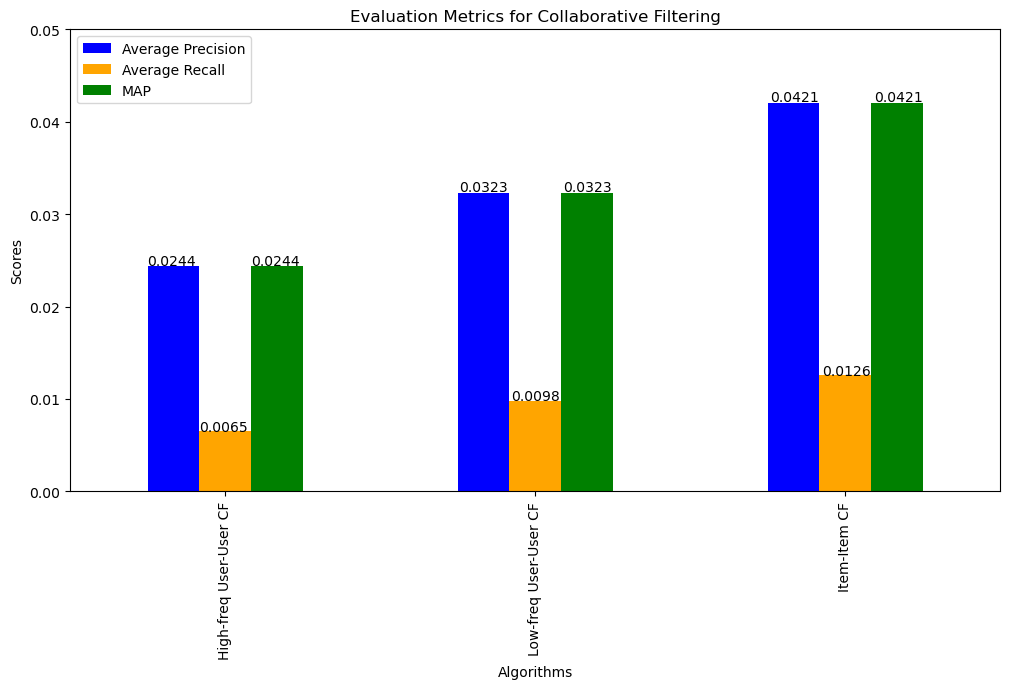

In [351]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Average Precision': [average_precision_high,average_precision_low, average_precision_item],
    'Average Recall': [average_recall_high,average_recall_low,average_recall_item],
    'MAP': [map_score_high, map_score_low, map_score_item]
}

algorithms = ['High-freq User-User CF', 'Low-freq User-User CF', 'Item-Item CF']
df = pd.DataFrame(data, index=algorithms)

plt.figure(figsize=(12, 6))

ax = df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange', 'green'])

plt.title('Evaluation Metrics for Collaborative Filtering')
plt.xlabel('Algorithms')
plt.ylabel('Scores')
plt.ylim(0, 0.05)  

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

<Figure size 1600x800 with 0 Axes>

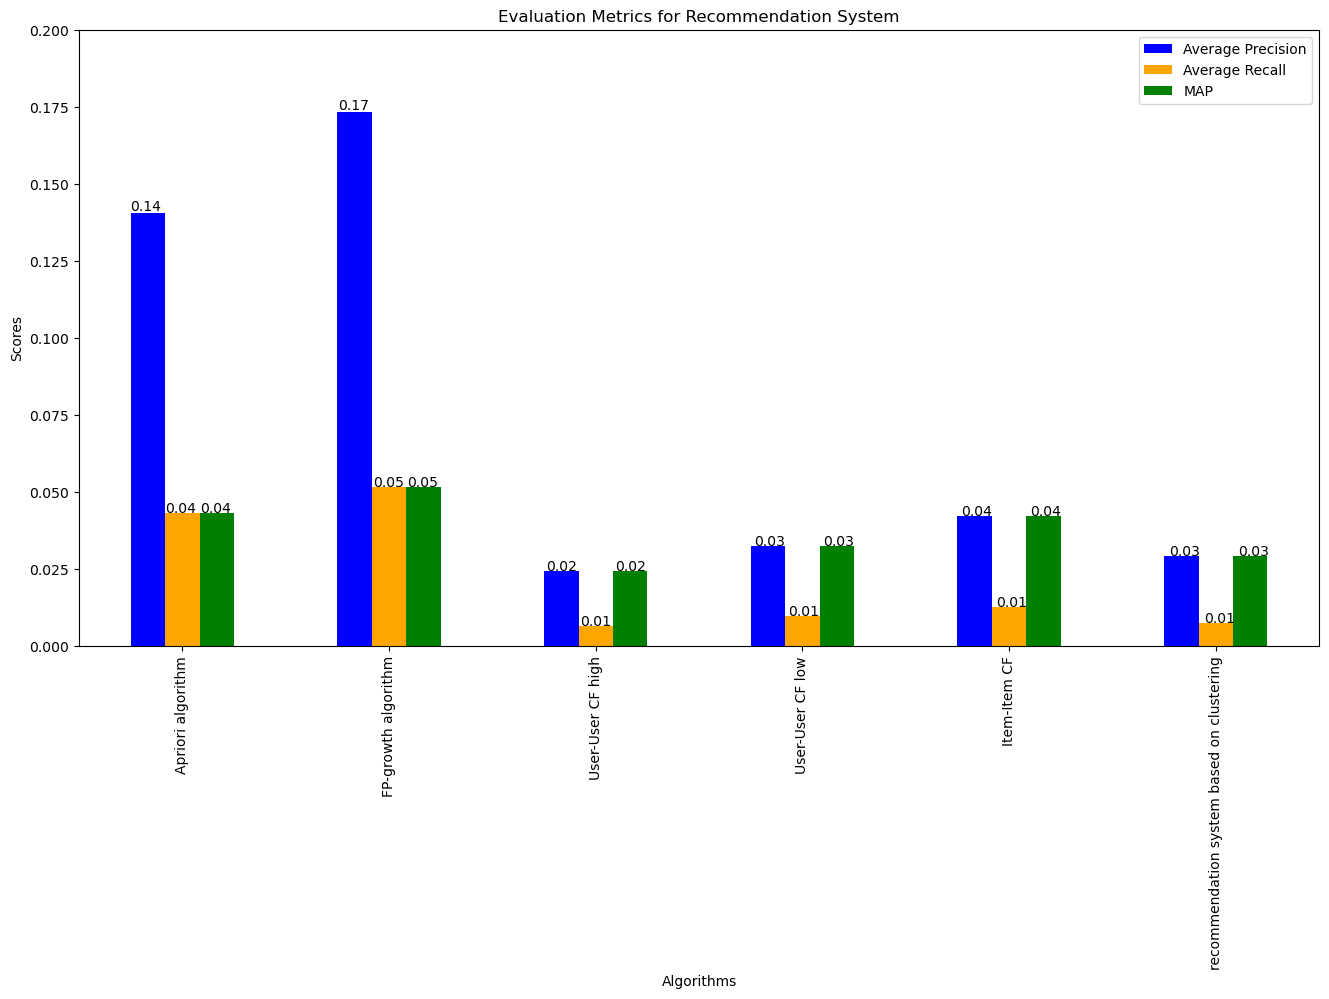

In [369]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Average Precision': [average_precision_apri, average_precision_FP,average_precision_high,average_precision_low, average_precision_item, average_precision_clustering],
    'Average Recall': [average_recall_apri, average_recall_FP,average_recall_high,average_recall_low,average_recall_item, average_recall_clustering],
    'MAP': [map_score_apri,map_score_FP, map_score_high, map_score_low, map_score_item, map_score_clustering]
}

algorithms = ['Apriori algorithm','FP-growth algorithm','User-User CF high', 'User-User CF low', 'Item-Item CF','recommendation system based on clustering']
df = pd.DataFrame(data, index=algorithms)

plt.figure(figsize=(16, 8))

ax = df.plot(kind='bar', figsize=(16, 8), color=['blue', 'orange', 'green'])

plt.title('Evaluation Metrics for Recommendation System')
plt.xlabel('Algorithms')
plt.ylabel('Scores')
plt.ylim(0, 0.2)  

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()



#### Visualisation of time

<Figure size 1200x600 with 0 Axes>

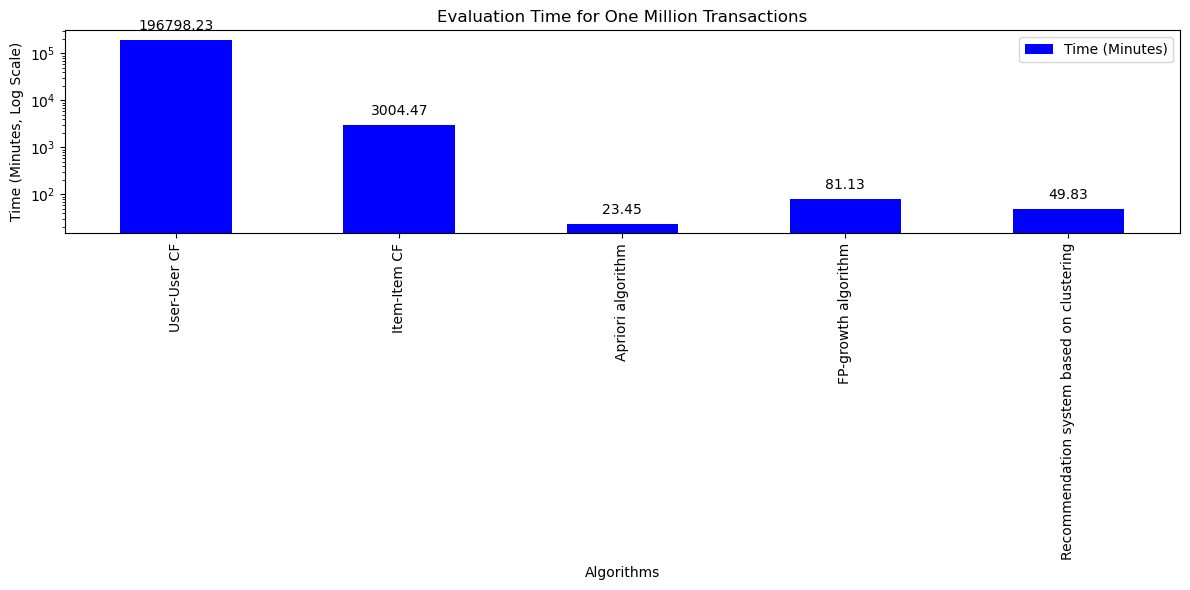

In [360]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Time (Minutes)': [T_B_user / 60, T_B_item / 60, T_B_apri / 60, T_B_FP / 60, T_B_Clustering / 60],
}

algorithms = ['User-User CF', 'Item-Item CF', 'Apriori algorithm', 'FP-growth algorithm', 'Recommendation system based on clustering']
df = pd.DataFrame(data, index=algorithms)

plt.figure(figsize=(12, 6))

ax = df.plot(kind='bar', figsize=(12, 6), color=['blue'], logy=True)

plt.title('Evaluation Time for One Million Transactions')
plt.xlabel('Algorithms')
plt.ylabel('Time (Minutes, Log Scale)')

# Annotate the bars with the exact values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()



### 6. References 

[1] workshop 10: A-priori/FP-growth algorithm

[2] Week 11 Workshop Solutions

[3] https://github.com/KOSASIH/TechnoGenius-Nexus/blob/main/recommend_items.py

[4] Yao, Liming & Xu, Zhongwen & Zhou, Xiaoyang & Lev, Benjamin. (2019). Synergies Between Association Rules and Collaborative Filtering in Recommender System: An Application to Auto Industry. 10.1007/978-3-319-95651-0_5. 